In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import pairwise_distances
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.spatial import ConvexHull

import sys

import matplotlib

font = {"size": 30}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

sys.path.append("../../util/")
from util import get_points_near_line


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:

DATA_DIR = "/Users/andrewjones/Documents/beehive/spatial-imputation/data/visium"
N_GENES = 50

## Load data
adata = sc.read_visium(DATA_DIR)
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
# print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=N_GENES, subset=True)


# genes = adata[:, adata.var.highly_variable].var_names.values[:100]
sq.gr.spatial_neighbors(adata)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
)

## Extract and normalize/standardize data
X = adata.obsm["spatial"].astype(float)
Y_full = np.array(adata[:, adata.uns["moranI"].index.values[:N_GENES]].X.todense()).squeeze()

X -= X.min(0)
X /= X.max(0)
X *= 10
X -= 5

Y_full = (Y_full - Y_full.mean(0)) / Y_full.std(0)

X += np.random.uniform(low=-0.25, high=0.25, size=X.shape)

/Users/andrewjones/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/andrewjones/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


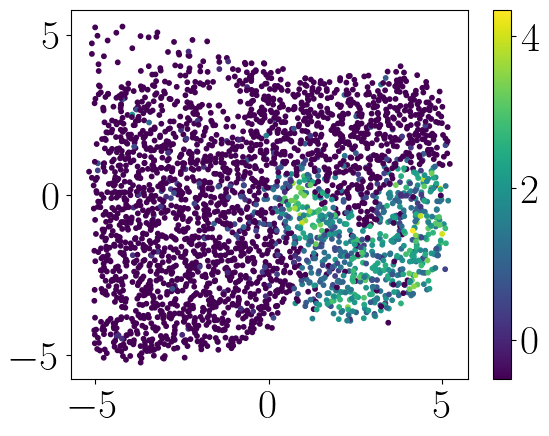

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=Y_full[:, 0], s=10)
plt.colorbar()
plt.show()

In [4]:


n_iters = 10

# When we take a slice, all points within this
# distance to the line/plane are "observed"
slice_radius = 0.05


# Discretize design space
n_slope_discretizations = 20
n_intercept_discretizations = 10
slope_angles = np.linspace(0, np.pi, n_slope_discretizations)
slopes = np.tan(slope_angles)
intercepts = np.linspace(
    np.min(X[:, 0]) + 1, np.max(X[:, 0]) - 1, n_intercept_discretizations
)
# intercepts = np.random.choice(np.unique(X[:, 1]), size=n_intercept_discretizations, replace=False)
designs1, designs2 = np.meshgrid(intercepts, slopes)
candidate_designs = np.vstack([designs1.ravel(), designs2.ravel()]).T

n_candidate_designs = len(candidate_designs)


designs = []
observed_idx = []
X_fragment_idx = [np.arange(len(X))]
r2_scores = np.zeros(n_iters)


for iternum in range(n_iters):
    print(iternum)

    assert len(designs) == iternum
    assert len(X_fragment_idx) == iternum + 1

    if len(observed_idx) > 0:
        kernel = RBF(length_scale=5) + WhiteKernel()
        gpr = GPR(kernel=kernel) #, optimizer=None)
        gpr.fit(
            X[np.unique(observed_idx)],
            Y_full[np.unique(observed_idx)],
        )
        noise_variance = np.exp(gpr.kernel_.k2.theta[0])

#         print(gpr.kernel_.k2.theta)

    best_eig = -np.inf
    best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

    for ff in range(len(X_fragment_idx)):

        # Get data for this fragment
        curr_X = X[X_fragment_idx[ff]]

        for dd in range(n_candidate_designs):

            # Get points that would be observed by this slice
            curr_design = candidate_designs[dd]

            above_fragment_idx = np.where(
                curr_X[:, 1] >= curr_design[0] + curr_X[:, 0] * curr_design[1]
            )[0]

            curr_observed_idx = get_points_near_line(
                X=curr_X,
                slope=curr_design[1],
                intercept=curr_design[0],
                slice_radius=slice_radius,
            )
            assert len(np.intersect1d(observed_idx, X_fragment_idx[ff][curr_observed_idx])) == 0

            L = len(curr_observed_idx)
            if L == 0:
                continue

            if iternum == 0:
                kernel = RBF(length_scale=5) + WhiteKernel()
                cov = kernel(curr_X[curr_observed_idx])
                noise_variance = np.exp(kernel.k2.theta[0])
            else:
                # Make predictions of expression
                _, cov = gpr.predict(curr_X[curr_observed_idx], return_cov=True)

            curr_eig = 0.5 * np.linalg.slogdet(1 / noise_variance * cov + np.eye(L))[1]

            if curr_eig > best_eig:
                best_design_idx = dd
                best_fragment_idx = ff
                best_observed_idx = X_fragment_idx[ff][curr_observed_idx]
                best_eig = curr_eig

    curr_best_design = candidate_designs[best_design_idx]

    best_fragment_X = X[X_fragment_idx[best_fragment_idx]]

    above_fragment_idx = np.where(
        best_fragment_X[:, 1]
        >= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
    )[0]
    below_fragment_idx = np.where(
        best_fragment_X[:, 1]
        <= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
    )[0]

    above_idx = X_fragment_idx[best_fragment_idx][above_fragment_idx]
    below_idx = X_fragment_idx[best_fragment_idx][below_fragment_idx]
    above_idx = np.setdiff1d(above_idx, best_observed_idx)
    below_idx = np.setdiff1d(below_idx, best_observed_idx)
    
    X_fragment_idx.pop(best_fragment_idx)
    X_fragment_idx.append(above_idx)
    X_fragment_idx.append(below_idx)

    designs.append(curr_best_design)
    observed_idx.extend(best_observed_idx)

    ## Run prediction
    train_idx = np.array(observed_idx)
    test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
    X_train, Y_train = X[train_idx], Y_full[train_idx]
    X_test, Y_test = X[test_idx], Y_full[test_idx]

    gpr = GPR(kernel=kernel) #, optimizer=None)
    gpr.fit(X_train, Y_train)
    preds = gpr.predict(X_test)
    curr_r2 = r2_score(Y_test, preds)
    r2_scores[iternum] = curr_r2



## Random design

n_repeats = 5
r2_scores_random = np.zeros((n_repeats, n_iters))

for rep_ii in range(n_repeats):
    designs_random = []
    observed_idx_random = []
    X_fragment_idx_random = [np.arange(len(X))]

    for iternum in range(n_iters):

        assert len(designs_random) == iternum
        assert len(X_fragment_idx_random) == iternum + 1

        curr_observed_idx = []
        while len(curr_observed_idx) == 0:
            rand_fragment_idx = np.random.choice(np.arange(len(X_fragment_idx_random)))
            rand_design_idx = np.random.choice(np.arange(n_candidate_designs))

            curr_design = candidate_designs[rand_design_idx]
            curr_X = X[X_fragment_idx_random[rand_fragment_idx]]
            curr_observed_idx = get_points_near_line(
                X=curr_X,
                slope=curr_design[1],
                intercept=curr_design[0],
                slice_radius=slice_radius,
            )
            
            assert len(np.intersect1d(observed_idx_random, X_fragment_idx_random[rand_fragment_idx][curr_observed_idx])) == 0

        best_fragment_X = X[X_fragment_idx_random[rand_fragment_idx]]

        observed_idx_random.extend(
            X_fragment_idx_random[rand_fragment_idx][curr_observed_idx].tolist()
        )

        above_fragment_idx = np.where(
            best_fragment_X[:, 1]
            >= curr_design[0] + best_fragment_X[:, 0] * curr_design[1]
        )[0]
        below_fragment_idx = np.where(
            best_fragment_X[:, 1]
            <= curr_design[0] + best_fragment_X[:, 0] * curr_design[1]
        )[0]

        above_idx = X_fragment_idx_random[rand_fragment_idx][above_fragment_idx]
        below_idx = X_fragment_idx_random[rand_fragment_idx][below_fragment_idx]
        above_idx = np.setdiff1d(above_idx, X_fragment_idx_random[rand_fragment_idx][curr_observed_idx])
        below_idx = np.setdiff1d(below_idx, X_fragment_idx_random[rand_fragment_idx][curr_observed_idx])
        X_fragment_idx_random.pop(rand_fragment_idx)
        X_fragment_idx_random.append(above_idx)
        X_fragment_idx_random.append(below_idx)

        designs_random.append(curr_design)

        train_idx = np.array(observed_idx_random)
        test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
        X_train, Y_train = X[train_idx], Y_full[train_idx]
        X_test, Y_test = X[test_idx], Y_full[test_idx]

        kernel = RBF(length_scale=5) + WhiteKernel()
        gpr = GPR(kernel=kernel)
        gpr.fit(X_train, Y_train)
        preds = gpr.predict(X_test)
        curr_r2 = r2_score(Y_test, preds)
        r2_scores_random[rep_ii, iternum] = curr_r2



## Naive design

r2_scores_naive = np.zeros((n_repeats, n_iters))

slopes = np.zeros(n_iters)
intercepts = np.linspace(
    np.min(X[:, 0]), np.max(X[:, 0]), n_iters + 2
)[1:-1]
designs1, designs2 = np.meshgrid(intercepts, slopes)
designs_naive = np.vstack([designs1.ravel(), designs2.ravel()]).T


design_indices = np.arange(n_iters)

for rep_ii in range(n_repeats):
    observed_idx_naive = []
    
    curr_shuffled_indices = np.random.choice(design_indices, size=len(design_indices), replace=False)

    for iternum, design_idx in enumerate(curr_shuffled_indices):

        curr_design = designs_naive[design_idx]

        curr_observed_idx = get_points_near_line(
            X=X,
            slope=curr_design[1],
            intercept=curr_design[0],
            slice_radius=slice_radius,
        )
        observed_idx_naive.extend(
            curr_observed_idx.tolist()
        )

        train_idx = np.array(observed_idx_naive)
        test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
        X_train, Y_train = X[train_idx], Y_full[train_idx]
        X_test, Y_test = X[test_idx], Y_full[test_idx]
        
        kernel = RBF() + WhiteKernel()
        gpr = GPR(kernel=kernel) #, optimizer=None)
        gpr.fit(X_train, Y_train)
        preds = gpr.predict(X_test)
        curr_r2 = r2_score(Y_test, preds)
        r2_scores_naive[rep_ii, iternum] = curr_r2




0
1
2
3
4
5
6
7
8
9


In [5]:
frac_drop = 0.5

mse_full_atlas = np.zeros(n_repeats)
for ii in range(n_repeats):
    
    # Randomly drop points
    test_idx = np.random.choice(np.arange(len(X)), size=int(frac_drop * len(X)), replace=False)
    train_idx = np.setdiff1d(np.arange(len(X)), test_idx)
    coords_train, outcome_train = X[train_idx], Y_full[train_idx]
    coords_test, outcome_test = X[test_idx], Y_full[test_idx]
    
    # Fit GP
    gpr = GPR(kernel=RBF() + WhiteKernel()) #, optimizer=None)
    gpr.fit(coords_train, outcome_train)
    
    # Make predictions for dropped points
    preds = gpr.predict(coords_test)
    
    # Compute R^2
    mse_full_atlas[ii] = r2_score(outcome_test, preds)
    print(mse_full_atlas[ii])
print(mse_full_atlas)

0.26345010301921895
0.2639267627052399
0.266980893878252
0.2618698597673508
0.2627731161805327
[0.2634501  0.26392676 0.26698089 0.26186986 0.26277312]


In [51]:
from scipy.spatial import Delaunay

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"
    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))
    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

def abline(slope, intercept, **kwargs):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, **kwargs)


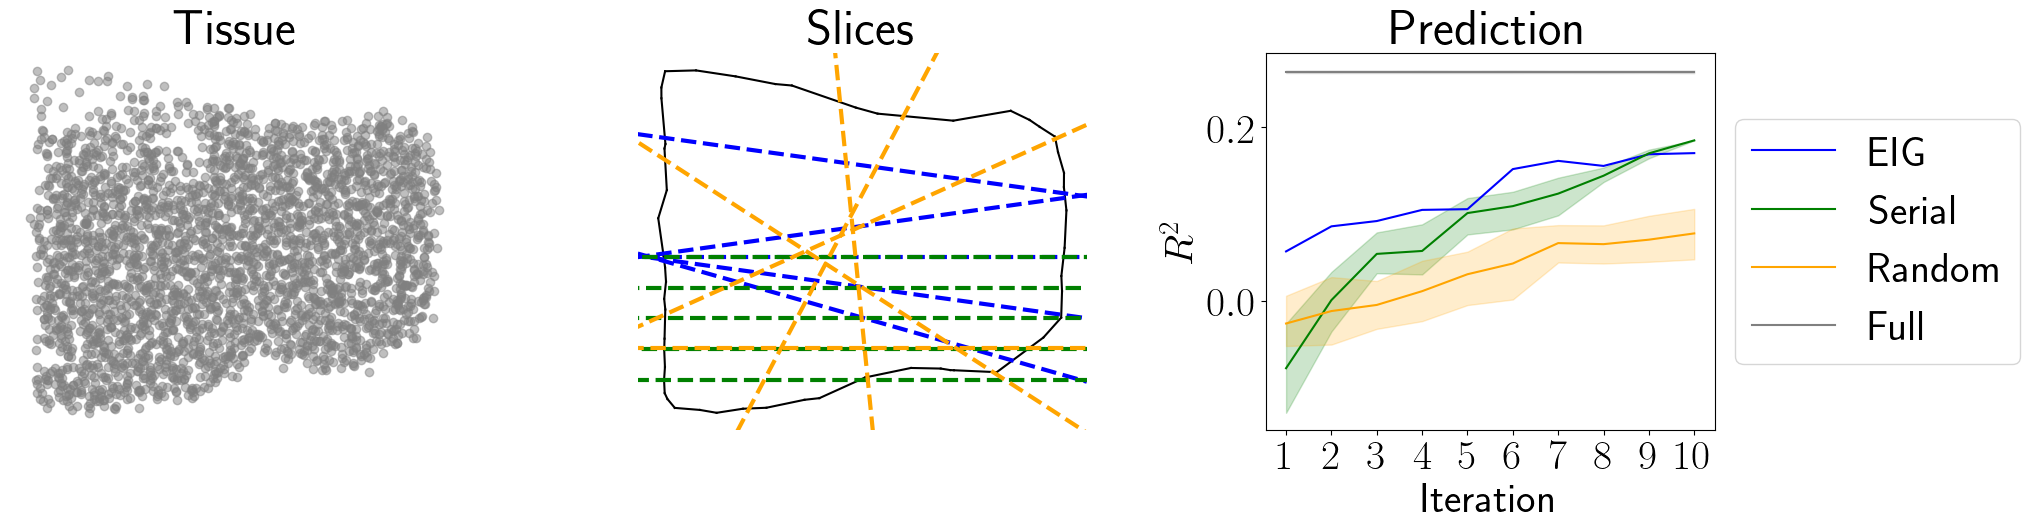

In [54]:

plt.figure(figsize=(21, 6))

plt.subplot(131)
plt.title("Tissue")
plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.5)
plt.axis("off")
plt.legend([],[], frameon=False)
# plt.tight_layout()

xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()

plt.subplot(132)
plt.title("Slices")
# plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.5)
# plt.scatter(X[np.array(observed_idx_random), 0], X[np.array(observed_idx_random), 1], label="Random", color="orange")
# plt.scatter(X[np.array(observed_idx_naive), 0], X[np.array(observed_idx_naive), 1], label="Naive", color="green")
# plt.scatter(X[np.array(observed_idx), 0], X[np.array(observed_idx), 1], label="Designed", color="blue")

edges = alpha_shape(X, alpha=3)

# plt.plot(X[:, 0], X[:, 1], '.')
for i, j in edges:
    plt.plot(X[[i, j], 0], X[[i, j], 1], c="black")
    
for dd in range(len(designs[:5])):
    abline(designs[dd][1], designs[dd][0], c="blue", linestyle="--", linewidth=3)

for dd in range(len(designs_naive[:5])):
    abline(designs_naive[dd][1], designs_naive[dd][0], c="green", linestyle="--", linewidth=3)    

for dd in range(len(designs_random[:5])):
    abline(designs_random[dd][1], designs_random[dd][0], c="orange", linestyle="--", linewidth=3)
    


plt.xlim(xlims)
plt.ylim(ylims)
plt.axis("off")
plt.legend([],[], frameon=False)
# plt.tight_layout()

plt.subplot(133)
plt.title("Prediction")

results_df = pd.DataFrame({"iter": np.arange(1, n_iters + 1), "r2": r2_scores})
# results_df_naive = pd.DataFrame({"iter": np.arange(1, n_iters + 1), "r2": r2_scores_naive})
results_df_naive = pd.melt(pd.DataFrame(r2_scores_naive))
results_df_naive["variable"] += 1
results_df_random = pd.melt(pd.DataFrame(r2_scores_random))
results_df_random["variable"] += 1

results_df_full_atlas = pd.DataFrame({"iter": results_df_random.variable.values, "r2": np.tile(mse_full_atlas, n_iters)})


sns.lineplot(data=results_df, x="iter", y="r2", label="EIG", color="blue")
# sns.lineplot(data=results_df_naive, x="iter", y="r2", label="Serial", color="green")
sns.lineplot(
    data=results_df_naive,
    x="variable",
    y="value",
    label="Serial",
    color="green",
)
sns.lineplot(
    data=results_df_random,
    x="variable",
    y="value",
    label="Random",
    color="orange",
)
sns.lineplot(
    data=results_df_full_atlas,
    x="iter",
    y="r2",
    label="Full",
    color="Gray",
)
plt.xticks(np.arange(1, n_iters + 1))
plt.xlabel("Iteration")
plt.ylabel(r"$R^2$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()


plt.savefig("./out/visium_prediction_experiment.png")
plt.show()


In [37]:
len(designs)

10

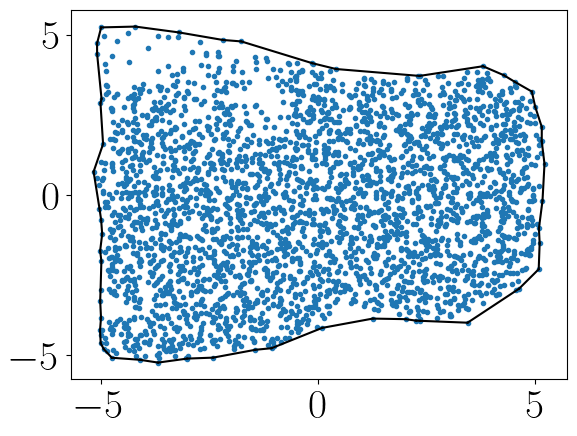

In [27]:
edges = alpha_shape(X, alpha=3)

plt.plot(X[:, 0], X[:, 1], '.')
for i, j in edges:
    plt.plot(X[[i, j], 0], X[[i, j], 1], c="black")
plt.show()